In [295]:
import os
import re
import sklearn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm

from collections import Counter
from sklearn.metrics import *
from sklearn.linear_model import *
from sklearn.model_selection import *

from xgboost import XGBClassifier, XGBRegressor

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

In [296]:
DATA_PATH = 'dsp_data/'
for filename in sorted(os.listdir(DATA_PATH)):
    print(filename)

2024_gt.csv
2024_test.csv
2024_test_R2.csv
2024_test_r3.csv
2024_test_r4.csv
2024_test_r5.csv
2024_test_r6.csv
2024_tourney_seeds.csv
Cities.csv
Conferences.csv
MConferenceTourneyGames.csv
MGameCities.csv
MMasseyOrdinals_thruSeason2024_day128.csv
MNCAATourneyCompactResults.csv
MNCAATourneyDetailedResults.csv
MNCAATourneySeedRoundSlots.csv
MNCAATourneySeeds.csv
MNCAATourneySlots.csv
MRegularSeasonCompactResults.csv
MRegularSeasonDetailedResults.csv
MSeasons.csv
MSecondaryTourneyCompactResults.csv
MSecondaryTourneyTeams.csv
MTeamCoaches.csv
MTeamConferences.csv
MTeamSpellings.csv
MTeams.csv
WGameCities.csv
WNCAATourneyCompactResults.csv
WNCAATourneyDetailedResults.csv
WNCAATourneySeeds.csv
WNCAATourneySlots.csv
WRegularSeasonCompactResults.csv
WRegularSeasonDetailedResults.csv
WSeasons.csv
WTeamConferences.csv
WTeamSpellings.csv
WTeams.csv
sample_submission.csv


## **Data Loading**

In [297]:
df_seeds = pd.read_csv(DATA_PATH + "MNCAATourneySeeds.csv")

df_seeds.head()

,Season,Seed,TeamID
0,1985,W01,1207
1,1985,W02,1210
2,1985,W03,1228
3,1985,W04,1260
4,1985,W05,1374


In [298]:
df_season_results = pd.read_csv(DATA_PATH + "MRegularSeasonDetailedResults.csv")

df_season_results.drop(['NumOT', 'WLoc'], axis=1, inplace=True)

In [299]:
df_season_results['ScoreGap'] = df_season_results['WScore'] - df_season_results['LScore']

In [300]:
df_season_results.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF,ScoreGap
0,2003,10,1104,68,1328,62,27,58,3,14,11,18,14,24,13,23,7,1,22,22,53,2,10,16,22,10,22,8,18,9,2,20,6
1,2003,10,1272,70,1393,63,26,62,8,20,10,19,15,28,16,13,4,4,18,24,67,6,24,9,20,20,25,7,12,8,6,16,7
2,2003,11,1266,73,1437,61,24,58,8,18,17,29,17,26,15,10,5,2,25,22,73,3,26,14,23,31,22,9,12,2,5,23,12
3,2003,11,1296,56,1457,50,18,38,3,9,17,31,6,19,11,12,14,2,18,18,49,6,22,8,15,17,20,9,19,4,3,23,6
4,2003,11,1400,77,1208,71,30,61,6,14,11,13,17,22,12,14,4,4,20,24,62,6,16,17,27,21,15,12,10,7,1,14,6


## **Features:**

**Compute:**

Number of Wins and Losses

Avg Score Gap in Wins and Losses

Points scored in Wins and Losses

Field Goal Percentage

Number of Two-pointers and three-pointers made

Number of free throws attempted and made

Number of offensive and defensive rebounds

Turnovers and Assists per game


**To Derive the Following Features:**

Assists per game

Blocks per game

Field Goal Percentage

Points per game

Rebounds per game

Effective Field Goal Percentage

True Shooting Percentage

Margin of Victory

Pythagorean Wins/Losses

Assist/Turnover Ratio

In [301]:
df_season_results.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF,ScoreGap
0,2003,10,1104,68,1328,62,27,58,3,14,11,18,14,24,13,23,7,1,22,22,53,2,10,16,22,10,22,8,18,9,2,20,6
1,2003,10,1272,70,1393,63,26,62,8,20,10,19,15,28,16,13,4,4,18,24,67,6,24,9,20,20,25,7,12,8,6,16,7
2,2003,11,1266,73,1437,61,24,58,8,18,17,29,17,26,15,10,5,2,25,22,73,3,26,14,23,31,22,9,12,2,5,23,12
3,2003,11,1296,56,1457,50,18,38,3,9,17,31,6,19,11,12,14,2,18,18,49,6,22,8,15,17,20,9,19,4,3,23,6
4,2003,11,1400,77,1208,71,30,61,6,14,11,13,17,22,12,14,4,4,20,24,62,6,16,17,27,21,15,12,10,7,1,14,6


In [302]:
num_win = df_season_results.groupby(['Season', 'WTeamID']).count()
num_win = num_win.reset_index()[['Season', 'WTeamID', 'DayNum']].rename(columns={"DayNum": "NumWins", "WTeamID": "TeamID"})

In [303]:
pts_win = df_season_results.groupby(['Season', 'WTeamID']).sum()
pts_win = pts_win.reset_index()[['Season', 'WTeamID', "WScore", "LScore"]].rename(columns={"WScore": "WTotalPoints", "WTeamID": "TeamID", "LScore": "LPointsAgainst"})

In [304]:
num_loss = df_season_results.groupby(['Season', 'LTeamID']).count()
num_loss = num_loss.reset_index()[['Season', 'LTeamID', 'DayNum']].rename(columns={"DayNum": "NumLosses", "LTeamID": "TeamID"})

In [305]:
pts_loss = df_season_results.groupby(['Season', 'LTeamID']).count()
pts_loss = pts_loss.reset_index()[['Season', 'LTeamID', 'LScore', "WScore"]].rename(columns={"LScore": "LTotalPoints", "LTeamID": "TeamID", "WScore": "WPointsAgainst"})

In [306]:
gap_win = df_season_results.groupby(['Season', 'WTeamID']).mean().reset_index()
gap_win = gap_win[['Season', 'WTeamID', 'ScoreGap']].rename(columns={"ScoreGap": "GapWins", "WTeamID": "TeamID"})

In [307]:
gap_loss = df_season_results.groupby(['Season', 'LTeamID']).mean().reset_index()
gap_loss = gap_loss[['Season', 'LTeamID', 'ScoreGap']].rename(columns={"ScoreGap": "GapLosses", "LTeamID": "TeamID"})

In [308]:
df_wefg = df_season_results.groupby(['Season', 'WTeamID']).sum()
df_wefg = df_wefg.reset_index()[['Season', 'WTeamID', 'WFGM', 'WFGA', 'WFGM3', 'WFGA3']].rename(columns={"WTeamID": "TeamID"})

In [309]:
df_lefg = df_season_results.groupby(['Season', 'LTeamID']).sum()
df_lefg = df_lefg.reset_index()[['Season', 'LTeamID', 'LFGM', 'LFGA', 'LFGM3', 'LFGA3']].rename(columns={"LTeamID": "TeamID"})

In [310]:
wts = df_season_results.groupby(['Season', 'WTeamID']).sum()
wts = wts.reset_index()[['Season', 'WTeamID', 'WScore', 'WFTA']].rename(columns={"WTeamID":"TeamID"})

In [311]:
lts = df_season_results.groupby(['Season', 'LTeamID']).sum()
lts = lts.reset_index()[['Season', 'LTeamID', 'LScore', 'LFTA']].rename(columns={"LTeamID": "TeamID"})

In [312]:
watv = df_season_results.groupby(['Season', 'WTeamID']).sum()
watv = watv.reset_index()[['Season', 'WTeamID', 'WAst', 'WTO']].rename(columns={"WTeamID": "TeamID"})

In [313]:
latv = df_season_results.groupby(['Season', 'LTeamID']).sum()
latv = latv.reset_index()[['Season', 'LTeamID', 'LAst', 'LTO']].rename(columns={"LTeamID": "TeamID"})

In [314]:
wrb = df_season_results.groupby(['Season', 'WTeamID']).sum()
wrb = wrb.reset_index()[['Season', 'WTeamID', 'WOR']].rename(columns={"WTeamID":"TeamID"})

In [315]:
lrb = df_season_results.groupby(['Season', 'LTeamID']).sum()
lrb = lrb.reset_index()[['Season', 'LTeamID', 'LOR']].rename(columns={"LTeamID":"TeamID"})

In [316]:
wagainst = df_season_results.groupby(['Season', 'WTeamID']).sum()
wagainst = wagainst.reset_index()[['Season', 'WTeamID', 'LFGA', 'LFTA', 'LOR', 'LTO']].rename(columns={"WTeamID":"TeamID", "LFGA":"WFGAopp", "LFTA":"WFTAopp", "LOR":"WORopp", "LTO":"WTOopp"})

In [317]:
lagainst = df_season_results.groupby(['Season', 'LTeamID']).sum()
lagainst = lagainst.reset_index()[['Season', 'LTeamID', 'WFGA', 'WFTA', 'WOR', 'WTO']].rename(columns={'LTeamID':"TeamID", 'WFGA':'LFGAopp', 'WFTA': 'LFTAopp', 'WOR': 'LORopp', 'WTO':'LTOopp'})

In [318]:
wdrb = df_season_results.groupby(['Season', 'WTeamID']).sum()
wdrb = wdrb.reset_index()[['Season', 'WTeamID', 'WDR']].rename(columns={"WTeamID":"TeamID"})

In [319]:
ldrb = df_season_results.groupby(['Season', 'LTeamID']).sum()
ldrb = ldrb.reset_index()[['Season', 'LTeamID', 'LDR']].rename(columns={"LTeamID":"TeamID"})

In [320]:
wbl = df_season_results.groupby(['Season', 'WTeamID']).sum()
wbl = wbl.reset_index()[['Season', 'WTeamID', 'WBlk']].rename(columns={"WTeamID":"TeamID"})

In [321]:
lbl = df_season_results.groupby(['Season', 'LTeamID']).sum()
lbl = lbl.reset_index()[['Season', 'LTeamID', 'LBlk']].rename(columns={"LTeamID":"TeamID"})

In [322]:
wstl = df_season_results.groupby(['Season', 'WTeamID']).sum()
wstl = wstl.reset_index()[['Season', 'WTeamID', 'WStl']].rename(columns={"WTeamID":"TeamID"})

In [323]:
lstl = df_season_results.groupby(['Season', 'LTeamID']).sum()
lstl = lstl.reset_index()[['Season', 'LTeamID', 'LStl']].rename(columns={"LTeamID":"TeamID"})

In [324]:
df_features_season_w = df_season_results.groupby(['Season', 'WTeamID']).count().reset_index()[['Season', 'WTeamID']].rename(columns={"WTeamID": "TeamID"})
df_features_season_l = df_season_results.groupby(['Season', 'LTeamID']).count().reset_index()[['Season', 'LTeamID']].rename(columns={"LTeamID": "TeamID"})

In [325]:
df_features_season = pd.concat([df_features_season_w, df_features_season_l], axis=0).drop_duplicates().sort_values(['Season', 'TeamID']).reset_index(drop=True)

In [326]:
df_features_season = df_features_season.merge(num_win, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(num_loss, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(gap_win, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(gap_loss, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(pts_win, on=["Season", 'TeamID'], how="left")
df_features_season = df_features_season.merge(pts_loss, on=["Season", 'TeamID'], how="left")
df_features_season = df_features_season.merge(df_wefg, on=["Season", 'TeamID'], how="left")
df_features_season = df_features_season.merge(df_lefg, on=["Season", 'TeamID'], how="left")
df_features_season = df_features_season.merge(wts, on=["Season", 'TeamID'], how="left")
df_features_season = df_features_season.merge(lts, on=["Season", 'TeamID'], how="left")
df_features_season = df_features_season.merge(watv, on=["Season", 'TeamID'], how="left")
df_features_season = df_features_season.merge(latv, on=["Season", 'TeamID'], how="left")
df_features_season = df_features_season.merge(wrb, on=["Season", 'TeamID'], how="left")
df_features_season = df_features_season.merge(lrb, on=["Season", 'TeamID'], how="left")
df_features_season = df_features_season.merge(wagainst, on=["Season", 'TeamID'], how="left")
df_features_season = df_features_season.merge(lagainst, on=["Season", 'TeamID'], how="left")
df_features_season = df_features_season.merge(wbl, on=["Season", 'TeamID'], how="left")
df_features_season = df_features_season.merge(lbl, on=["Season", 'TeamID'], how="left")
df_features_season = df_features_season.merge(wdrb, on=["Season", 'TeamID'], how="left")
df_features_season = df_features_season.merge(ldrb, on=["Season", 'TeamID'], how="left")
df_features_season = df_features_season.merge(wstl, on=["Season", 'TeamID'], how="left")
df_features_season = df_features_season.merge(lstl, on=["Season", 'TeamID'], how="left")

In [327]:
df_features_season.fillna(0, inplace=True)

In [328]:
df_features_season['BPG'] = (df_features_season['WBlk'] + df_features_season['LBlk']) / (df_features_season['NumWins'] + df_features_season['NumLosses'])

In [329]:
df_features_season['SPG'] = (df_features_season['WStl'] + df_features_season['LStl']) / (df_features_season['NumWins'] + df_features_season['NumLosses'])

In [330]:
df_features_season['RPG'] = (df_features_season['WOR'] + df_features_season['LOR']+ df_features_season['LDR'] + df_features_season['WDR']) / (df_features_season['NumWins'] + df_features_season['NumLosses'])

In [331]:
df_features_season['PPG'] = (df_features_season['WScore'] + df_features_season['LScore']) / (df_features_season['NumWins'] + df_features_season['NumLosses'])

In [332]:
df_features_season['APG'] = (df_features_season['WAst'] + df_features_season['LAst']) / (df_features_season['NumWins'] + df_features_season['NumLosses'])

In [333]:
df_features_season.drop(['WBlk', 'LBlk'], axis=1, inplace=True)

In [334]:
df_features_season.drop(['WStl', 'LStl'], axis=1, inplace=True)

In [335]:
df_features_season.drop(['WDR', 'LDR'], axis=1, inplace=True)

In [336]:
df_features_season.drop(['NumWins', 'NumLosses', 'GapWins', 'GapLosses'], axis=1, inplace=True)

In [337]:
df_features_season.drop(['WTotalPoints', 'LTotalPoints', 'LPointsAgainst', 'WPointsAgainst'], axis=1, inplace=True)

In [338]:
df_features_season['2PFGM'] = df_features_season['WFGM'] + df_features_season['LFGM'] - df_features_season['WFGM3'] -df_features_season['LFGM3']
df_features_season["FGA"] = df_features_season['WFGA'] + df_features_season['LFGA']
df_features_season['3PFGM'] = df_features_season['WFGA3'] + df_features_season['WFGA3']

df_features_season['FGPct'] = (df_features_season["2PFGM"] + df_features_season["3PFGM"]) / (df_features_season["FGA"])
df_features_season.drop(['2PFGM', '3PFGM'], axis=1, inplace=True)

In [339]:
df_features_season["ORBopp"] = df_features_season['WORopp'] + df_features_season['LORopp']
df_features_season['TOVopp'] = df_features_season['WTOopp'] + df_features_season['LTOopp']
df_features_season["FGAopp"] = df_features_season['LFGAopp'] + df_features_season['WFGAopp']
df_features_season['FTAopp'] = df_features_season['LFTAopp'] + df_features_season['WFTAopp']
df_features_season['OppPos'] = 0.5*(df_features_season['FGAopp']+ (0.475*df_features_season['FTAopp']) - df_features_season['ORBopp'] + df_features_season['TOVopp'])

In [340]:
df_features_season.drop(['WOR', 'LOR', 'OppPos', 'ORBopp', 'TOVopp', 'FGAopp', 'FTAopp'], axis =1, inplace=True)

In [341]:
df_features_season.drop(['WORopp', 'LORopp', 'WTOopp', 'LTOopp', 'LFGAopp', 'WFGAopp', 'WFTAopp', 'LFTAopp'], axis=1, inplace=True)

In [342]:
df_features_season.drop(['WFGM', 'WFGA', "WFGM3", "WFGA3", 'LFGM', 'LFGA', "LFGM3", "LFGA3", "FGA", "WScore", "LScore", "LFTA", "WFGA", "WFTA", 'WAst', 'LAst', 'WTO', 'LTO'], axis=1, inplace=True)

In [343]:
# Filter to include years 2016 and beyond
df_features_season = df_features_season[df_features_season['Season'] >= 2016]

In [344]:
df_seeds = df_seeds[df_seeds["Season"] >= 2016]
df_seeds["Seed"] = df_seeds["Seed"].apply(lambda x: int(re.sub(r"\D", "", x)))
df_seeds.head()

,Season,Seed,TeamID
2014,2016,1,1314
2015,2016,2,1462
2016,2016,3,1452
2017,2016,4,1246
2018,2016,5,1231


In [345]:
# add seed to teamid and season
df_features_season = df_seeds.merge(df_features_season, on=["Season", "TeamID"], how="left")

In [346]:
df_features_season.head()

,Season,Seed,TeamID,BPG,SPG,RPG,PPG,APG,FGPct
0,2016,1,1314,4.382353,6.882353,40.970588,82.264706,18.117647,0.841335
1,2016,2,1462,3.062500,7.312500,41.000000,81.343750,16.375000,0.891125
2,2016,3,1452,2.529412,9.941176,39.176471,79.205882,14.764706,0.821951
3,2016,4,1246,5.647059,5.617647,38.588235,79.676471,14.411765,0.823558
4,2016,5,1231,3.968750,6.937500,37.375000,82.281250,15.968750,0.981760


In [347]:
tourney_results = pd.read_csv(DATA_PATH + "MNCAATourneyCompactResults.csv")
tourney_results.drop(['WLoc', 'NumOT'], axis=1, inplace=True)
tourney_results = tourney_results[tourney_results['Season'] >= 2016]
tourney_results.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore
1983,2016,134,1195,96,1192,65
1984,2016,134,1455,70,1435,50
1985,2016,135,1221,59,1380,55
1986,2016,135,1276,67,1409,62
1987,2016,136,1114,85,1345,83


In [348]:
tourney_results.drop(['DayNum','WScore','LScore'], axis=1,inplace=True)
print(tourney_results.shape)

(468, 3)


In [349]:
df_test = tourney_results
df_test['Pred'] = 0.5
# increment ID for df_test column
df_test['ID'] = df_test.index
df_test

,Season,WTeamID,LTeamID,Pred,ID
1983,2016,1195,1192,0.5,1983
1984,2016,1455,1435,0.5,1984
1985,2016,1221,1380,0.5,1985
1986,2016,1276,1409,0.5,1986
1987,2016,1114,1345,0.5,1987
...,...,...,...,...,...
2446,2023,1274,1400,0.5,2446
2447,2023,1361,1166,0.5,2447
2448,2023,1163,1274,0.5,2448
2449,2023,1361,1194,0.5,2449


In [350]:
# merge features for winning team, returns NaN for every entry, not working correctly
df_test = df_test.merge(df_features_season, left_on=["Season", "WTeamID"], right_on=["Season", "TeamID"], how="left")
# rename columns to W prefix
df_test.rename(columns={"Seed": "WSeed", "BPG": "WBPG", "APG" : "WAPG", "PPG" : "WPPG", "RPG" : "WRPG", "SPG" : "WSPG", "FGPct" : "WFGPct"}, inplace=True)
# drop teamid column
df_test.drop("TeamID", axis=1, inplace=True)

# merge features for losing team, returns NaN for every entry, not working correctly
df_test = df_test.merge(df_features_season, left_on=["Season", "LTeamID"], right_on=["Season", "TeamID"], how="left")
# rename columns to L prefix
df_test.rename(columns={"Seed": "LSeed", "BPG": "LBPG", "APG" : "LAPG", "PPG" : "LPPG", "RPG" : "LRPG", "SPG" : "LSPG", "FGPct" : "LFGPct"}, inplace=True)
# drop teamid column
df_test.drop("TeamID", axis=1, inplace=True)
df_test

,Season,WTeamID,LTeamID,Pred,ID,WSeed,WBPG,WSPG,WRPG,WPPG,WAPG,WFGPct,LSeed,LBPG,LSPG,LRPG,LPPG,LAPG,LFGPct
0,2016,1195,1192,0.5,1983,16,4.034483,6.137931,39.413793,75.586207,12.896552,0.652698,16,2.516129,7.354839,33.129032,76.838710,14.096774,0.714362
1,2016,1455,1435,0.5,1984,11,3.580645,7.258065,37.483871,73.129032,14.322581,0.832312,11,5.531250,4.312500,38.562500,76.750000,14.937500,0.762870
2,2016,1221,1380,0.5,1985,16,2.515152,6.454545,30.121212,65.333333,13.909091,0.612325,16,3.322581,7.354839,35.419355,71.225806,10.322581,0.696478
3,2016,1276,1409,0.5,1986,11,2.090909,5.424242,32.030303,74.424242,14.969697,0.841515,11,2.677419,6.806452,35.032258,74.000000,13.709677,0.784161
4,2016,1114,1345,0.5,1987,12,3.064516,6.290323,32.903226,70.000000,12.903226,0.916372,5,4.647059,4.264706,40.823529,77.735294,17.588235,0.886364
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
463,2023,1274,1400,0.5,2446,5,3.281250,7.343750,31.875000,79.406250,14.937500,0.894130,2,3.647059,8.058824,31.735294,77.852941,15.911765,0.869990
464,2023,1361,1166,0.5,2447,5,3.718750,7.125000,32.656250,71.343750,13.031250,0.888950,6,4.181818,5.242424,34.757576,76.636364,15.909091,0.841997
465,2023,1163,1274,0.5,2448,4,4.878788,6.545455,35.939394,78.454545,17.272727,0.937910,5,3.281250,7.343750,31.875000,79.406250,14.937500,0.894130
466,2023,1361,1194,0.5,2449,5,3.718750,7.125000,32.656250,71.343750,13.031250,0.888950,9,2.531250,6.500000,35.187500,78.156250,14.218750,1.095962


In [351]:
# decrease df test to only include rows that don't have nan's
df_test = df_test.dropna()
df_test

,Season,WTeamID,LTeamID,Pred,ID,WSeed,WBPG,WSPG,WRPG,WPPG,WAPG,WFGPct,LSeed,LBPG,LSPG,LRPG,LPPG,LAPG,LFGPct
0,2016,1195,1192,0.5,1983,16,4.034483,6.137931,39.413793,75.586207,12.896552,0.652698,16,2.516129,7.354839,33.129032,76.838710,14.096774,0.714362
1,2016,1455,1435,0.5,1984,11,3.580645,7.258065,37.483871,73.129032,14.322581,0.832312,11,5.531250,4.312500,38.562500,76.750000,14.937500,0.762870
2,2016,1221,1380,0.5,1985,16,2.515152,6.454545,30.121212,65.333333,13.909091,0.612325,16,3.322581,7.354839,35.419355,71.225806,10.322581,0.696478
3,2016,1276,1409,0.5,1986,11,2.090909,5.424242,32.030303,74.424242,14.969697,0.841515,11,2.677419,6.806452,35.032258,74.000000,13.709677,0.784161
4,2016,1114,1345,0.5,1987,12,3.064516,6.290323,32.903226,70.000000,12.903226,0.916372,5,4.647059,4.264706,40.823529,77.735294,17.588235,0.886364
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
463,2023,1274,1400,0.5,2446,5,3.281250,7.343750,31.875000,79.406250,14.937500,0.894130,2,3.647059,8.058824,31.735294,77.852941,15.911765,0.869990
464,2023,1361,1166,0.5,2447,5,3.718750,7.125000,32.656250,71.343750,13.031250,0.888950,6,4.181818,5.242424,34.757576,76.636364,15.909091,0.841997
465,2023,1163,1274,0.5,2448,4,4.878788,6.545455,35.939394,78.454545,17.272727,0.937910,5,3.281250,7.343750,31.875000,79.406250,14.937500,0.894130
466,2023,1361,1194,0.5,2449,5,3.718750,7.125000,32.656250,71.343750,13.031250,0.888950,9,2.531250,6.500000,35.187500,78.156250,14.218750,1.095962


In [352]:
# create a new column that is the difference between the winning and losing team's features
df_test["SeedDiff"] = df_test["WSeed"] - df_test["LSeed"]
df_test["BPGDiff"] = df_test["WBPG"] - df_test["LBPG"]
df_test["APGDiff"] = df_test["WAPG"] - df_test["LAPG"]
df_test["PPGDiff"] = df_test["WPPG"] - df_test["LPPG"]
df_test["RPGDiff"] = df_test["WRPG"] - df_test["LRPG"]
df_test["SPGDiff"] = df_test["WSPG"] - df_test["LSPG"]
df_test["FGPctDiff"] = df_test["WFGPct"] - df_test["LFGPct"]

# drop columns that are not needed
df_test.drop(["WSeed", "LSeed", "WBPG", "LBPG", "WAPG", "LAPG", "WPPG", "LPPG", "WRPG", "LRPG", "WSPG", "LSPG", "WFGPct", "LFGPct"], axis=1, inplace=True)

df_test

,Season,WTeamID,LTeamID,Pred,ID,SeedDiff,BPGDiff,APGDiff,PPGDiff,RPGDiff,SPGDiff,FGPctDiff
0,2016,1195,1192,0.5,1983,0,1.518354,-1.200222,-1.252503,6.284761,-1.216908,-0.061664
1,2016,1455,1435,0.5,1984,0,-1.950605,-0.614919,-3.620968,-1.078629,2.945565,0.069442
2,2016,1221,1380,0.5,1985,0,-0.807429,3.586510,-5.892473,-5.298143,-0.900293,-0.084154
3,2016,1276,1409,0.5,1986,0,-0.586510,1.260020,0.424242,-3.001955,-1.382209,0.057355
4,2016,1114,1345,0.5,1987,7,-1.582543,-4.685009,-7.735294,-7.920304,2.025617,0.030009
...,...,...,...,...,...,...,...,...,...,...,...,...
463,2023,1274,1400,0.5,2446,3,-0.365809,-0.974265,1.553309,0.139706,-0.715074,0.024140
464,2023,1361,1166,0.5,2447,-1,-0.463068,-2.877841,-5.292614,-2.101326,1.882576,0.046953
465,2023,1163,1274,0.5,2448,-1,1.597538,2.335227,-0.951705,4.064394,-0.798295,0.043780
466,2023,1361,1194,0.5,2449,-4,1.187500,-1.187500,-6.812500,-2.531250,0.625000,-0.207012


In [353]:
# train a model
# rename pred to Win
df_test.rename(columns={"Pred": "Win"}, inplace=True)
df_test["Win"] = 1
df_test

,Season,WTeamID,LTeamID,Win,ID,SeedDiff,BPGDiff,APGDiff,PPGDiff,RPGDiff,SPGDiff,FGPctDiff
0,2016,1195,1192,1,1983,0,1.518354,-1.200222,-1.252503,6.284761,-1.216908,-0.061664
1,2016,1455,1435,1,1984,0,-1.950605,-0.614919,-3.620968,-1.078629,2.945565,0.069442
2,2016,1221,1380,1,1985,0,-0.807429,3.586510,-5.892473,-5.298143,-0.900293,-0.084154
3,2016,1276,1409,1,1986,0,-0.586510,1.260020,0.424242,-3.001955,-1.382209,0.057355
4,2016,1114,1345,1,1987,7,-1.582543,-4.685009,-7.735294,-7.920304,2.025617,0.030009
...,...,...,...,...,...,...,...,...,...,...,...,...
463,2023,1274,1400,1,2446,3,-0.365809,-0.974265,1.553309,0.139706,-0.715074,0.024140
464,2023,1361,1166,1,2447,-1,-0.463068,-2.877841,-5.292614,-2.101326,1.882576,0.046953
465,2023,1163,1274,1,2448,-1,1.597538,2.335227,-0.951705,4.064394,-0.798295,0.043780
466,2023,1361,1194,1,2449,-4,1.187500,-1.187500,-6.812500,-2.531250,0.625000,-0.207012


In [354]:
# rename WTeamID to TeamIDA and LTeamID to TeamIDB
df_test.rename(columns={"WTeamID": "TeamIDA", "LTeamID": "TeamIDB"}, inplace=True)
df_test

,Season,TeamIDA,TeamIDB,Win,ID,SeedDiff,BPGDiff,APGDiff,PPGDiff,RPGDiff,SPGDiff,FGPctDiff
0,2016,1195,1192,1,1983,0,1.518354,-1.200222,-1.252503,6.284761,-1.216908,-0.061664
1,2016,1455,1435,1,1984,0,-1.950605,-0.614919,-3.620968,-1.078629,2.945565,0.069442
2,2016,1221,1380,1,1985,0,-0.807429,3.586510,-5.892473,-5.298143,-0.900293,-0.084154
3,2016,1276,1409,1,1986,0,-0.586510,1.260020,0.424242,-3.001955,-1.382209,0.057355
4,2016,1114,1345,1,1987,7,-1.582543,-4.685009,-7.735294,-7.920304,2.025617,0.030009
...,...,...,...,...,...,...,...,...,...,...,...,...
463,2023,1274,1400,1,2446,3,-0.365809,-0.974265,1.553309,0.139706,-0.715074,0.024140
464,2023,1361,1166,1,2447,-1,-0.463068,-2.877841,-5.292614,-2.101326,1.882576,0.046953
465,2023,1163,1274,1,2448,-1,1.597538,2.335227,-0.951705,4.064394,-0.798295,0.043780
466,2023,1361,1194,1,2449,-4,1.187500,-1.187500,-6.812500,-2.531250,0.625000,-0.207012


In [355]:
# Vary the Wins by randomly selecting a subset of the rows
# Set Win to 0 for the subset and negate the difference columns
df_test.loc[df_test.sample(frac=0.5).index, "Win"] = 0
df_test.loc[df_test["Win"] == 0, "SeedDiff"] = -df_test.loc[df_test["Win"] == 0, "SeedDiff"]
df_test.loc[df_test["Win"] == 0, "BPGDiff"] = -df_test.loc[df_test["Win"] == 0, "BPGDiff"]
df_test.loc[df_test["Win"] == 0, "APGDiff"] = -df_test.loc[df_test["Win"] == 0, "APGDiff"]
df_test.loc[df_test["Win"] == 0, "PPGDiff"] = -df_test.loc[df_test["Win"] == 0, "PPGDiff"]
df_test.loc[df_test["Win"] == 0, "RPGDiff"] = -df_test.loc[df_test["Win"] == 0, "RPGDiff"]
df_test.loc[df_test["Win"] == 0, "SPGDiff"] = -df_test.loc[df_test["Win"] == 0, "SPGDiff"]
df_test.loc[df_test["Win"] == 0, "FGPctDiff"] = -df_test.loc[df_test["Win"] == 0, "FGPctDiff"]
df_test

,Season,TeamIDA,TeamIDB,Win,ID,SeedDiff,BPGDiff,APGDiff,PPGDiff,RPGDiff,SPGDiff,FGPctDiff
0,2016,1195,1192,0,1983,0,-1.518354,1.200222,1.252503,-6.284761,1.216908,0.061664
1,2016,1455,1435,0,1984,0,1.950605,0.614919,3.620968,1.078629,-2.945565,-0.069442
2,2016,1221,1380,1,1985,0,-0.807429,3.586510,-5.892473,-5.298143,-0.900293,-0.084154
3,2016,1276,1409,0,1986,0,0.586510,-1.260020,-0.424242,3.001955,1.382209,-0.057355
4,2016,1114,1345,1,1987,7,-1.582543,-4.685009,-7.735294,-7.920304,2.025617,0.030009
...,...,...,...,...,...,...,...,...,...,...,...,...
463,2023,1274,1400,1,2446,3,-0.365809,-0.974265,1.553309,0.139706,-0.715074,0.024140
464,2023,1361,1166,1,2447,-1,-0.463068,-2.877841,-5.292614,-2.101326,1.882576,0.046953
465,2023,1163,1274,1,2448,-1,1.597538,2.335227,-0.951705,4.064394,-0.798295,0.043780
466,2023,1361,1194,1,2449,-4,1.187500,-1.187500,-6.812500,-2.531250,0.625000,-0.207012


In [356]:
# train a model
X = df_test.drop(["ID", "Season", "Win", "TeamIDA", "TeamIDB"], axis=1)
y = df_test["Win"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = XGBClassifier(random_state=42)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [357]:
# make predictions
preds = model.predict_proba(X_test)[:, 1]

# calculate log loss
print(log_loss(y_test, preds))

# AUC
print(roc_auc_score(y_test, preds))

0.8944604973826804
0.6815462494247585


In [358]:
# print team names
df_teams = pd.read_csv(DATA_PATH + "MTeams.csv")
df_teams

,TeamID,TeamName,FirstD1Season,LastD1Season
0,1101,Abilene Chr,2014,2024
1,1102,Air Force,1985,2024
2,1103,Akron,1985,2024
3,1104,Alabama,1985,2024
4,1105,Alabama A&M,2000,2024
...,...,...,...,...
373,1474,Queens NC,2023,2024
374,1475,Southern Indiana,2023,2024
375,1476,Stonehill,2023,2024
376,1477,TX A&M Commerce,2023,2024


In [359]:
test_file = pd.read_csv(DATA_PATH + "2024_test.csv")
test_file

,ID,Season,TeamIDA,TeamIDB
0,1,2024,1163,1391
1,2,2024,1194,1321
2,3,2024,1361,1412
3,4,2024,1120,1463
4,5,2024,1140,1182
5,6,2024,1228,1287
6,7,2024,1450,1179
7,8,2024,1235,1355
8,9,2024,1314,1224
9,10,2024,1280,1277


In [360]:
# join features for team A
test_file = test_file.merge(df_features_season, left_on=["Season", "TeamIDA"], right_on=["Season", "TeamID"], how="left")
test_file.rename(columns={"Seed": "SeedA", "BPG": "BPGA", "APG" : "APGA", "PPG" : "PPGA", "RPG" : "RPGA", "SPG" : "SPGA", "FGPct" : "FGPctA"}, inplace=True)
test_file.drop("TeamID", axis=1, inplace=True)

# join features for team B
test_file = test_file.merge(df_features_season, left_on=["Season", "TeamIDB"], right_on=["Season", "TeamID"], how="left")
test_file.rename(columns={"Seed": "SeedB", "BPG": "BPGB", "APG" : "APGB", "PPG" : "PPGB", "RPG" : "RPGB", "SPG" : "SPGB", "FGPct" : "FGPctB"}, inplace=True)
test_file.drop("TeamID", axis=1, inplace=True)

test_file

,ID,Season,TeamIDA,TeamIDB,SeedA,BPGA,SPGA,RPGA,PPGA,APGA,FGPctA,SeedB,BPGB,SPGB,RPGB,PPGB,APGB,FGPctB
0,1,2024,1163,1391,1,5.382353,6.235294,35.264706,81.470588,18.529412,1.098295,16,2.967742,4.903226,29.580645,74.483871,12.677419,0.828604
1,2,2024,1194,1321,8,3.030303,7.121212,34.909091,82.545455,15.000000,0.931582,9,3.281250,6.906250,28.875000,73.687500,15.625000,0.782205
2,3,2024,1361,1412,5,4.062500,7.250000,33.875000,74.187500,13.031250,0.833155,12,4.727273,6.515152,35.393939,77.393939,13.242424,0.732653
3,4,2024,1120,1463,4,6.205882,7.411765,34.470588,83.323529,17.911765,0.941973,13,3.310345,5.793103,33.137931,73.551724,14.655172,0.821553
4,5,2024,1140,1182,6,3.000000,5.939394,36.212121,81.848485,18.606061,0.981888,11,4.382353,7.470588,31.676471,70.058824,13.205882,0.830042
5,6,2024,1228,1287,3,3.794118,4.235294,38.058824,84.411765,13.000000,0.910596,14,4.366667,5.633333,33.633333,72.433333,13.433333,0.943271
6,7,2024,1450,1179,7,4.696970,5.272727,35.303030,74.303030,12.545455,0.811340,10,1.575758,6.393939,31.757576,80.272727,15.878788,0.994914
7,8,2024,1235,1355,2,3.058824,10.441176,31.000000,75.558824,15.735294,0.857932,15,3.000000,5.935484,31.483871,75.516129,12.709677,0.801018
8,9,2024,1314,1224,1,4.029412,5.794118,38.235294,81.470588,14.470588,0.871059,16,2.906250,5.906250,31.937500,74.656250,13.593750,0.682179
9,10,2024,1280,1277,8,3.088235,8.088235,35.088235,74.764706,13.941176,0.800811,9,3.909091,7.151515,31.878788,73.121212,16.303030,0.687404


In [361]:
# calculate difference columns
test_file["SeedDiff"] = test_file["SeedA"] - test_file["SeedB"]
test_file["BPGDiff"] = test_file["BPGA"] - test_file["BPGB"]
test_file["APGDiff"] = test_file["APGA"] - test_file["APGB"]
test_file["PPGDiff"] = test_file["PPGA"] - test_file["PPGB"]
test_file["RPGDiff"] = test_file["RPGA"] - test_file["RPGB"]
test_file["SPGDiff"] = test_file["SPGA"] - test_file["SPGB"]
test_file["FGPctDiff"] = test_file["FGPctA"] - test_file["FGPctB"]

In [362]:
# drop columns that are not needed
test_file.drop(["SeedA", "SeedB", "BPGA", "BPGB", "APGA", "APGB", "PPGA", "PPGB", "SPGA", "SPGB", "RPGA", "RPGB", "FGPctA", "FGPctB"], axis=1, inplace=True)
test_file

,ID,Season,TeamIDA,TeamIDB,SeedDiff,BPGDiff,APGDiff,PPGDiff,RPGDiff,SPGDiff,FGPctDiff
0,1,2024,1163,1391,-15,2.414611,5.851992,6.986717,5.684061,1.332068,0.269691
1,2,2024,1194,1321,-1,-0.250947,-0.625000,8.857955,6.034091,0.214962,0.149376
2,3,2024,1361,1412,-7,-0.664773,-0.211174,-3.206439,-1.518939,0.734848,0.100502
3,4,2024,1120,1463,-9,2.895538,3.256592,9.771805,1.332657,1.618661,0.120420
4,5,2024,1140,1182,-5,-1.382353,5.400178,11.789661,4.535651,-1.531194,0.151846
5,6,2024,1228,1287,-11,-0.572549,-0.433333,11.978431,4.425490,-1.398039,-0.032675
6,7,2024,1450,1179,-3,3.121212,-3.333333,-5.969697,3.545455,-1.121212,-0.183573
7,8,2024,1235,1355,-13,0.058824,3.025617,0.042694,-0.483871,4.505693,0.056914
8,9,2024,1314,1224,-15,1.123162,0.876838,6.814338,6.297794,-0.112132,0.188879
9,10,2024,1280,1277,-1,-0.820856,-2.361854,1.643494,3.209447,0.936720,0.113407


In [363]:
# make predictions on 2024 data
X_24 = test_file.drop(["ID", "Season", "TeamIDA", "TeamIDB"], axis=1)
preds = model.predict_proba(X_24)[:, 1]

In [364]:
# create submission file
submission = pd.DataFrame()
submission["ID"] = test_file["ID"]
submission["Pred"] = preds
submission.to_csv("submission.csv", index=False)
submission

,ID,Pred
0,1,0.992032
1,2,0.976438
2,3,0.862492
3,4,0.994867
4,5,0.315937
5,6,0.235955
6,7,0.679580
7,8,0.996647
8,9,0.983554
9,10,0.308510


In [365]:
# Get AUC between the preds and 2024_gt.csv whic is the ground truth of round 1
gt = pd.read_csv(DATA_PATH + "2024_gt.csv")
# get first 32 entries
gt = gt[:32]
gt

,ID,Season,TeamIDA,TeamIDB,Win
0,1,2024,1163,1391,1
1,2,2024,1194,1321,0
2,3,2024,1361,1412,1
3,4,2024,1120,1463,0
4,5,2024,1140,1182,0
5,6,2024,1228,1287,1
6,7,2024,1450,1179,1
7,8,2024,1235,1355,1
8,9,2024,1314,1224,1
9,10,2024,1280,1277,0


In [366]:
# merge the ground truth with the submission
submission = submission.merge(gt, on="ID", how="left")
submission

,ID,Pred,Season,TeamIDA,TeamIDB,Win
0,1,0.992032,2024,1163,1391,1
1,2,0.976438,2024,1194,1321,0
2,3,0.862492,2024,1361,1412,1
3,4,0.994867,2024,1120,1463,0
4,5,0.315937,2024,1140,1182,0
5,6,0.235955,2024,1228,1287,1
6,7,0.679580,2024,1450,1179,1
7,8,0.996647,2024,1235,1355,1
8,9,0.983554,2024,1314,1224,1
9,10,0.308510,2024,1280,1277,0


In [367]:
# AUC
print(roc_auc_score(submission["Win"], submission["Pred"]))

0.5324675324675325


In [368]:
# get second round prediction
test_r2 = pd.read_csv(DATA_PATH + "2024_test_R2.csv")

In [369]:
# join features for team A
test_r2 = test_r2.merge(df_features_season, left_on=["Season", "TeamIDA"], right_on=["Season", "TeamID"], how="left")
test_r2.rename(columns={"Seed": "SeedA", "BPG": "BPGA", "APG" : "APGA", "PPG" : "PPGA", "RPG" : "RPGA", "SPG" : "SPGA", "FGPct" : "FGPctA"}, inplace=True)
test_r2.drop("TeamID", axis=1, inplace=True)

# join features for team B
test_r2 = test_r2.merge(df_features_season, left_on=["Season", "TeamIDB"], right_on=["Season", "TeamID"], how="left")
test_r2.rename(columns={"Seed": "SeedB", "BPG": "BPGB", "APG" : "APGB", "PPG" : "PPGB", "RPG" : "RPGB", "SPG" : "SPGB", "FGPct" : "FGPctB"}, inplace=True)
test_r2.drop("TeamID", axis=1, inplace=True)

In [370]:
# calculate difference columns
test_r2["SeedDiff"] = test_r2["SeedA"] - test_r2["SeedB"]
test_r2["BPGDiff"] = test_r2["BPGA"] - test_r2["BPGB"]
test_r2["APGDiff"] = test_r2["APGA"] - test_r2["APGB"]
test_r2["PPGDiff"] = test_r2["PPGA"] - test_r2["PPGB"]
test_r2["RPGDiff"] = test_r2["RPGA"] - test_r2["RPGB"]
test_r2["SPGDiff"] = test_r2["SPGA"] - test_r2["SPGB"]
test_r2["FGPctDiff"] = test_r2["FGPctA"] - test_r2["FGPctB"]

In [371]:
# drop columns that are not needed
test_r2.drop(["SeedA", "SeedB",  "BPGA", "BPGB", "APGA", "APGB", "PPGA", "PPGB", "SPGA", "SPGB", "RPGA", "RPGB", "FGPctA", "FGPctB"], axis=1, inplace=True)

In [372]:
# make predictions on 2024 data
X_r2 = test_r2.drop(["ID", "Season", "TeamIDA", "TeamIDB"], axis=1)
preds_r2 = model.predict_proba(X_r2)[:, 1]

In [373]:
# create submission file
submission_r2 = pd.DataFrame()
submission_r2["ID"] = test_r2["ID"]
submission_r2["Pred"] = preds_r2
#submission_r2.to_csv("submission_r2.csv", index=False)
submission_r2

,ID,Pred
0,33,0.992059
1,34,0.008163
2,35,0.674559
3,36,0.549532
4,37,0.783242
5,38,0.027244
6,39,0.080160
7,40,0.326703
8,41,0.366163
9,42,0.371132


In [374]:
# round 3 simulation
test_r3 = pd.read_csv(DATA_PATH + "2024_test_r3.csv")

In [375]:
# join features for Team A
test_r3 = test_r3.merge(df_features_season, left_on=["Season", "TeamIDA"], right_on=["Season", "TeamID"], how="left")
test_r3.rename(columns={"Seed": "SeedA", "BPG" : "BPGA", "APG" : "APGA", "PPG" : "PPGA", "RPG" : "RPGA", "SPG" : "SPGA", "FGPct" : "FGPctA"}, inplace=True)
test_r3.drop("TeamID", axis=1, inplace=True)

# join features for team B
test_r3 = test_r3.merge(df_features_season, left_on=["Season", "TeamIDB"], right_on=["Season", "TeamID"], how="left")
test_r3.rename(columns={"Seed": "SeedB", "BPG" : "BPGB", "APG" : "APGB", "PPG" : "PPGB", "RPG" : "RPGB", "SPG" : "SPGB", "FGPct" : "FGPctB"}, inplace=True)
test_r3.drop("TeamID", axis=1, inplace=True)

In [376]:
# calculate difference columns
test_r3["SeedDiff"] = test_r3["SeedA"] - test_r3["SeedB"]
test_r3["BPGDiff"] = test_r3["BPGA"] - test_r3["BPGB"]
test_r3["APGDiff"] = test_r3["APGA"] - test_r3["APGB"]
test_r3["PPGDiff"] = test_r3["PPGA"] - test_r3["PPGB"]
test_r3["RPGDiff"] = test_r3["RPGA"] - test_r3["RPGB"]
test_r3["SPGDiff"] = test_r3["SPGA"] - test_r3["SPGB"]
test_r3["FGPctDiff"] = test_r3["FGPctA"] - test_r3["FGPctB"]

In [377]:
test_r3.drop(["SeedA", "SeedB", "BPGA", "BPGB", "APGA", "APGB", "PPGA", "PPGB", "SPGA", "SPGB", "RPGA", "RPGB", "FGPctA", "FGPctB"], axis=1, inplace=True)

In [378]:
# make predictions on 2024 data
X_r3 = test_r3.drop(["ID", "Season", "TeamIDA", "TeamIDB"], axis=1)
preds_r3 = model.predict_proba(X_r3)[:, 1]


In [379]:
# create submission file
submission_r3 = pd.DataFrame()
submission_r3["ID"] = test_r3["ID"]
submission_r3["Pred"] = preds_r3
#submission_r2.to_csv("submission_r2.csv", index=False)
submission_r3

,ID,Pred
0,49,0.981077
1,50,0.534826
2,51,0.424084
3,52,0.223086
4,53,0.008888
5,54,0.406295
6,55,0.897809
7,56,0.397791


In [380]:
# round 4 simulation
test_r4 = pd.read_csv(DATA_PATH + "2024_test_r4.csv")

# join features for Team A
test_r4 = test_r4.merge(df_features_season, left_on=["Season", "TeamIDA"], right_on=["Season", "TeamID"], how="left")
test_r4.rename(columns={"Seed": "SeedA", "BPG" : "BPGA", "APG" : "APGA", "PPG" : "PPGA", "RPG" : "RPGA", "SPG" : "SPGA", "FGPct" : "FGPctA"}, inplace=True)
test_r4.drop("TeamID", axis=1, inplace=True)

# join features for team B
test_r4 = test_r4.merge(df_features_season, left_on=["Season", "TeamIDB"], right_on=["Season", "TeamID"], how="left")
test_r4.rename(columns={"Seed": "SeedB", "BPG" : "BPGB", "APG" : "APGB", "PPG" : "PPGB", "RPG" : "RPGB", "SPG" : "SPGB", "FGPct" : "FGPctB"}, inplace=True)
test_r4.drop("TeamID", axis=1, inplace=True)

# calculate difference columns
test_r4["SeedDiff"] = test_r4["SeedA"] - test_r4["SeedB"]
test_r4["BPGDiff"] = test_r4["BPGA"] - test_r4["BPGB"]
test_r4["APGDiff"] = test_r4["APGA"] - test_r4["APGB"]
test_r4["PPGDiff"] = test_r4["PPGA"] - test_r4["PPGB"]
test_r4["RPGDiff"] = test_r4["RPGA"] - test_r4["RPGB"]
test_r4["SPGDiff"] = test_r4["SPGA"] - test_r4["SPGB"]
test_r4["FGPctDiff"] = test_r4["FGPctA"] - test_r4["FGPctB"]

In [381]:
test_r4.drop(["SeedA", "SeedB", "BPGA", "BPGB", "APGA", "APGB", "PPGA", "PPGB", "SPGA", "SPGB", "RPGA", "RPGB", "FGPctA", "FGPctB"], axis=1, inplace=True)

In [382]:
# make predictions on 2024 data
X_r4 = test_r4.drop(["ID", "Season", "TeamIDA", "TeamIDB"], axis=1)
preds_r4 = model.predict_proba(X_r4)[:, 1]

In [383]:
# create submission file
submission_r4 = pd.DataFrame()
submission_r4["ID"] = test_r4["ID"]
submission_r4["Pred"] = preds_r4
#submission_r2.to_csv("submission_r2.csv", index=False)
submission_r4

,ID,Pred
0,57,0.388613
1,58,0.424084
2,59,0.232579
3,60,0.987489


In [384]:
# round 5 simulation
test_r5 = pd.read_csv(DATA_PATH + "2024_test_r5.csv")

# join features for Team A
test_r5 = test_r5.merge(df_features_season, left_on=["Season", "TeamIDA"], right_on=["Season", "TeamID"], how="left")
test_r5.rename(columns={"Seed": "SeedA", "BPG" : "BPGA", "APG" : "APGA", "PPG" : "PPGA", "RPG" : "RPGA", "SPG" : "SPGA", "FGPct" : "FGPctA"}, inplace=True)
test_r5.drop("TeamID", axis=1, inplace=True)

# join features for team B
test_r5 = test_r5.merge(df_features_season, left_on=["Season", "TeamIDB"], right_on=["Season", "TeamID"], how="left")
test_r5.rename(columns={"Seed": "SeedB", "BPG" : "BPGB", "APG" : "APGB", "PPG" : "PPGB", "RPG" : "RPGB", "SPG" : "SPGB", "FGPct" : "FGPctB"}, inplace=True)
test_r5.drop("TeamID", axis=1, inplace=True)

# calculate difference columns
test_r5["SeedDiff"] = test_r5["SeedA"] - test_r5["SeedB"]
test_r5["BPGDiff"] = test_r5["BPGA"] - test_r5["BPGB"]
test_r5["APGDiff"] = test_r5["APGA"] - test_r5["APGB"]
test_r5["PPGDiff"] = test_r5["PPGA"] - test_r5["PPGB"]
test_r5["RPGDiff"] = test_r5["RPGA"] - test_r5["RPGB"]
test_r5["SPGDiff"] = test_r5["SPGA"] - test_r5["SPGB"]
test_r5["FGPctDiff"] = test_r5["FGPctA"] - test_r5["FGPctB"]

test_r5.drop(["SeedA", "SeedB", "BPGA", "BPGB", "APGA", "APGB", "PPGA", "PPGB", "SPGA", "SPGB", "RPGA", "RPGB", "FGPctA", "FGPctB"], axis=1, inplace=True)

In [385]:
# make predictions on 2024 data
X_r5 = test_r5.drop(["ID", "Season", "TeamIDA", "TeamIDB"], axis=1)
preds_r5 = model.predict_proba(X_r5)[:, 1]

# create submission file
submission_r5 = pd.DataFrame()
submission_r5["ID"] = test_r5["ID"]
submission_r5["Pred"] = preds_r5
#submission_r2.to_csv("submission_r2.csv", index=False)
submission_r5

,ID,Pred
0,61,0.679278
1,62,0.603393


In [386]:
# Champion
# round 5 simulation
test_r6 = pd.read_csv(DATA_PATH + "2024_test_r6.csv")

# join features for Team A
test_r6 = test_r6.merge(df_features_season, left_on=["Season", "TeamIDA"], right_on=["Season", "TeamID"], how="left")
test_r6.rename(columns={"Seed": "SeedA", "BPG" : "BPGA", "APG" : "APGA", "PPG" : "PPGA", "RPG" : "RPGA", "SPG" : "SPGA", "FGPct" : "FGPctA"}, inplace=True)
test_r6.drop("TeamID", axis=1, inplace=True)

# join features for team B
test_r6 = test_r6.merge(df_features_season, left_on=["Season", "TeamIDB"], right_on=["Season", "TeamID"], how="left")
test_r6.rename(columns={"Seed": "SeedB", "BPG" : "BPGB", "APG" : "APGB", "PPG" : "PPGB", "RPG" : "RPGB", "SPG" : "SPGB", "FGPct" : "FGPctB"}, inplace=True)
test_r6.drop("TeamID", axis=1, inplace=True)

# calculate difference columns
test_r6["SeedDiff"] = test_r6["SeedA"] - test_r6["SeedB"]
test_r6["BPGDiff"] = test_r6["BPGA"] - test_r6["BPGB"]
test_r6["APGDiff"] = test_r6["APGA"] - test_r6["APGB"]
test_r6["PPGDiff"] = test_r6["PPGA"] - test_r6["PPGB"]
test_r6["RPGDiff"] = test_r6["RPGA"] - test_r6["RPGB"]
test_r6["SPGDiff"] = test_r6["SPGA"] - test_r6["SPGB"]
test_r6["FGPctDiff"] = test_r6["FGPctA"] - test_r6["FGPctB"]

test_r6.drop(["SeedA", "SeedB", "BPGA", "BPGB", "APGA", "APGB", "PPGA", "PPGB", "SPGA", "SPGB", "RPGA", "RPGB", "FGPctA", "FGPctB"], axis=1, inplace=True)

In [387]:
# make predictions on 2024 data
X_r6 = test_r6.drop(["ID", "Season", "TeamIDA", "TeamIDB"], axis=1)
preds_r6 = model.predict_proba(X_r6)[:, 1]

# create submission file
submission_r6 = pd.DataFrame()
submission_r6["ID"] = test_r6["ID"]
submission_r6["Pred"] = preds_r6
#submission_r2.to_csv("submission_r2.csv", index=False)
submission_r6

,ID,Pred
0,63,0.596952


In [388]:
# whole tournament AUC
gt = pd.read_csv(DATA_PATH + "2024_gt.csv")

In [389]:
test_file = gt.copy()
test_file.drop(["Win"], axis=1, inplace=True)

# join features for A team
test_file = test_file.merge(df_features_season, left_on=["Season", "TeamIDA"], right_on=["Season", "TeamID"], how="left")
test_file.rename(columns={"Seed": "SeedA", "BPG" : "BPGA", "APG" : "APGA", "PPG" : "PPGA", "RPG" : "RPGA", "SPG" : "SPGA", "FGPct" : "FGPctA"}, inplace=True)
test_file.drop("TeamID", axis=1, inplace=True)

# join features for B team
test_file = test_file.merge(df_features_season, left_on=["Season", "TeamIDB"], right_on=["Season", "TeamID"], how="left")
test_file.rename(columns={"Seed": "SeedB", "BPG" : "BPGB", "APG" : "APGB", "PPG" : "PPGB", "RPG" : "RPGB", "SPG" : "SPGB", "FGPct" : "FGPctB"}, inplace=True)
test_file.drop("TeamID", axis=1, inplace=True)

# calculate difference columns
test_file["SeedDiff"] = test_file["SeedA"] - test_file["SeedB"]
test_file["BPGDiff"] = test_file["BPGA"] - test_file["BPGB"]
test_file["APGDiff"] = test_file["APGA"] - test_file["APGB"]
test_file["PPGDiff"] = test_file["PPGA"] - test_file["PPGB"]
test_file["RPGDiff"] = test_file["RPGA"] - test_file["RPGB"]
test_file["SPGDiff"] = test_file["SPGA"] - test_file["SPGB"]
test_file["FGPctDiff"] = test_file["FGPctA"] - test_file["FGPctB"]

# drop columns that are not needed
test_file.drop(["SeedA", "SeedB", "BPGA", "BPGB", "APGA", "APGB", "PPGA", "PPGB", "SPGA", "SPGB", "RPGA", "RPGB", "FGPctA", "FGPctB"], axis=1, inplace=True)

In [390]:
# make predictions on 2024 data
X_trny = test_file.drop(["ID", "Season", "TeamIDA", "TeamIDB"], axis=1)
preds_trny = model.predict_proba(X_trny)[:, 1]

# create submission file
submission_trny = pd.DataFrame()
submission_trny["ID"] = test_file["ID"]
submission_trny["Pred"] = preds_trny
# submission_trny.to_csv("submission_trny.csv", index=False)

In [391]:
# merge the ground truth with the submission
submission_trny = submission_trny.merge(gt, on="ID", how="left")
submission_trny

,ID,Pred,Season,TeamIDA,TeamIDB,Win
0,1,0.992032,2024,1163,1391,1
1,2,0.976438,2024,1194,1321,0
2,3,0.862492,2024,1361,1412,1
3,4,0.994867,2024,1120,1463,0
4,5,0.315937,2024,1140,1182,0
...,...,...,...,...,...,...
58,59,0.860420,2024,1345,1397,1
59,60,0.548228,2024,1301,1181,1
60,61,0.797022,2024,1163,1104,1
61,62,0.015335,2024,1301,1345,0


In [392]:
# AUC
print(roc_auc_score(submission_trny["Win"], submission_trny["Pred"]))

0.6630434782608696


In [393]:
# print feature importance with feature name
for feature, importance in zip(X.columns, model.feature_importances_):
    print(feature, importance)

SeedDiff 0.33043754
BPGDiff 0.09746526
APGDiff 0.11223811
PPGDiff 0.089377716
RPGDiff 0.11464935
SPGDiff 0.14653692
FGPctDiff 0.10929509


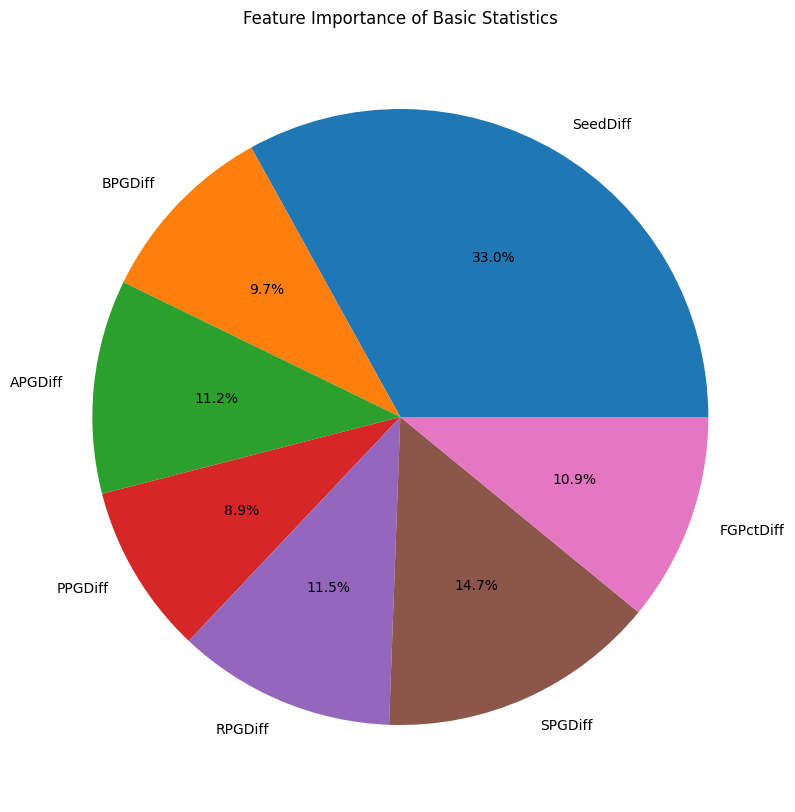

In [395]:
# pie chart of feature importance
plt.figure(figsize=(10, 10))
plt.pie(model.feature_importances_, labels=X.columns, autopct="%1.1f%%")
plt.title("Feature Importance of Basic Statistics")
plt.show()